Chaining: Chaining Parametric To Inversion
==========================================

Before reading this example, make sure you have read the `autolens_workspace/notebooks/interferometer/modeling/chaining/api.py`
example script, which describes phase chaining and details the API for this.

In this example, we chain two phases, where:

- Both phases model the lens galaxy's mass as an `EllipticalIsothermal`, with the lens's light omitted.
    
- The first phase models the source galaxy using a parametric `EllipticalSersic` profile.
    
- The second phase models the source galaxy using an `Inversion`, where its `EllipticalIsothermal` mass model
priors are initialized using the results of phase 1.

There are a number of benefits to chaining a parametric source model to an _Inversion, as opposed to fitting the
`Inversion` in one phase:

- Parametric sources are computationally faster to evaluate and fit to the data than an `Inversion`. Thus, although
the `EllipticalSersic` carries with it more parameters that the `NonLinearSearch` will have to fit for, the
model-fit will be faster overall given the increased speed of each log likelihood evaluation.

- `Inversion`'s often go to unphysical solutions where the mass model goes to extremely high / low normalizations
and the source is reconstructed as a demagnified version of the lensed source (see Chapter 4, tutorial 6 for a
complete description of this effect). A powerful way to prevent this from happening is to initialize the mass
model with a fit using a parametric source (which does not suffer these unphysical solutions) and use this result
to ensure the `NonLinearSearch` samples only the maximal likelihood regions of parameter space.
      
- To further remove these solutions, we use the `auto_positions` feature of the `SettingsPhaseInterferometer`, which use
the maximum log likelihood mass model of the first phase to determine the positions in the image-plane the
brightest regions of the lensed source trace too. In phase 2, mass models must trace these positions into a
threshold arc-secoond value of one another in the source-plane, ensuring the incorrect solutions corresponding to
unphysically large / small mass models are removed.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


As per usual, load the `Interferometer` data, create the real space mask. In this strong lensing dataset:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:176: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


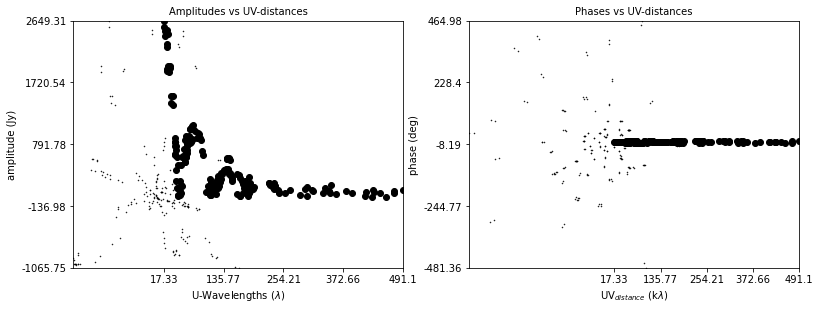

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()

The perform a fit, we need two masks, firstly a ‘real-space mask’ which defines the grid the image of the lensed 
source galaxy is evaluated using.

In [3]:
real_space_mask = al.Mask2D.circular(
    shape_native=(151, 151), pixel_scales=0.05, radius=3.0
)

We also need a ‘visibilities mask’ which defining which visibilities are omitted from the chi-squared evaluation.

In [4]:
visibilities_mask = np.full(fill_value=False, shape=interferometer.visibilities.shape)

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - An `EllipticalIsothermal` `MassProfile`.for the lens galaxy's mass (5 parameters).
 - An `EllipticalSersic` `LightProfile`.for the source galaxy's light (6 parameters) in phase 1.
 - An `Inversion` in phase 2 (3 parameters).

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=11.

In [5]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

You should be familiar with the `SettingsPhaseInterferometer` object from other example scripts, if not checkout 
the beginner examples and `autolens_workspace/notebooks/interferometer/modeling/customize/settings.py`

In this example we use the `auto_positions` inputs. These positions correspond to the brightest pixels of the lensed 
source's multiple images. When a phase uses positions, during model-fitting they must trace within a threshold value of 
one another for every mass model sampled by the non-linear search. If they do not, the model is discard and resampled. 
The setting below lead to the following behaviour for each phase:

- In phase 1, because no positions are input into the `Interferometer` dataset, positions are not used and the 
auto_positions settings do nothing.

- In phase 2, because there are auto_positions settings, the maximum log likelihood model of phase 1 is used too 
compute the positions of the lensed source galaxy and the threshold within which they trace to one another. This
threshold is multiplied by the `auto_positions_factor` to ensure it is not too small (and thus does not remove many 
plausible mass models). If, after this multiplication, the threshold is below the `auto_positions_minimum_threshold`, 
it is rounded up to this minimum value.

In [6]:
settings_lens = al.SettingsLens(
    auto_positions_factor=3.0, auto_positions_minimum_threshold=0.2
)
settings_masked_interferometer = al.SettingsMaskedInterferometer(
    grid_class=al.Grid2D, sub_size=1, transformer_class=al.TransformerNUFFT
)
settings_inversion = al.SettingsInversion(use_linear_operators=True)

settings = al.SettingsPhaseInterferometer(
    settings_lens=settings_lens,
    settings_masked_interferometer=settings_masked_interferometer,
    settings_inversion=settings_inversion,
)

__Search__

You should be familiar with non-linear searches from other example scripts if not checkout the beginner examples
and `autolens_workspace/notebooks/interferometer/modeling/customize/non_linear_searches.py`.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/chaining/parametric_to_inversion/mass_sie__source_sersic/phase[1]`.

In [7]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", "chaining", "parametric_to_inversion"),
    name="phase[1]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [8]:
phase1 = al.PhaseInterferometer(
    search=search,
    real_space_mask=real_space_mask,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

phase1_result = phase1.run(dataset=interferometer, mask=visibilities_mask)

INFO:root:phase[1] already completed, skipping non-linear search.


Before reading on to phase 2, you may wish to inspect the results of the phase 1 model-fit to ensure the fast
non-linear search has provided a reasonably accurate lens model.

__Model Chaining__

We use the results of phase 1 to create the `GalaxyModel` components that we fit in phase 2.

The term `model` below tells PyAutoLens to pass the lens and source models as model-components that are to be fitted
for by the non-linear search. In other chaining examples, we'll see other ways to pass prior results.

In [9]:
lens = phase1_result.model.galaxies.lens
source = al.GalaxyModel(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification,
    regularization=al.reg.Constant,
)

source.regularization.coefficient = af.LogUniformPrior(
    lower_limit=1e-3, upper_limit=1e4
)

__Search__

In phase 2, we use the nested sampling algorithm `Dynesty` again.

In [10]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", "chaining", "parametric_to_inversion"),
    name="phase[2]",
    n_live_points=40,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/chaining/parametric_to_inversion/mass_sie__source_sersic/phase[2]`.

Note how the `lens` passed to this phase was set up above using the results of phase 1!

In [11]:
phase2 = al.PhaseInterferometer(
    search=search,
    real_space_mask=real_space_mask,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)


phase2.run(dataset=interferometer, mask=visibilities_mask)

INFO:root:phase[2] already completed, skipping non-linear search.


__Wrap Up__

In this example, we passed used prior passing to initialize a lens mass model using a parametric source and pass this
model to a second phase which modeled the source using an `Inversion`. We won in terms of efficiency and ensuring the
`Inversion` did not go to an unphysical solution.

__Pipelines__

The next level of PyAutoLens uses `Pipelines`, which chain together multiple phases to perform very complex lens 
modeling in robust and efficient ways. Pipelines which fit the source as an `Inversion`, for example:

 `autolens_wokspace/pipelines/no_lens_light/mass_total__source_inversion.py`

Exploit our ability to first model the source using a parametric profile and then switch to an `Inversion`, to ensure 
more efficient and robust model-fits!